In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
conf = (SparkConf()
         .setMaster("local")
         .setAppName("CitibikeCluster")
         .set("spark.executor.memory", "1g"))

In [3]:
sc = SparkContext(conf = conf)

In [4]:
sql = SQLContext(sc)

In [95]:
#Input files into dataframe
inputFile = "s3://citibikeraw/train/*.csv"
trips = (sql.read
         .format("com.databricks.spark.csv")
         .options(header = 'true', inferschema='false')
         .load(inputFile))

#change all the column types
trips = trips.withColumn("tripduration", trips["tripduration"].cast("int"))
trips = trips.withColumn("start_station_id", trips["start station id"].cast("int"))
trips = trips.withColumn("start_station_latitude", round(trips["start station latitude"].cast("double"), 5))
trips = trips.withColumn("start_station_longitude", round(trips["start station longitude"].cast("double"), 5))
trips = trips.withColumn("end_station_id", trips["end station id"].cast("int"))
trips = trips.withColumn("end_station_latitude", round(trips["end station latitude"].cast("double"), 5))
trips = trips.withColumn("end_station_longitude", round(trips["end station longitude"].cast("double"), 5))
trips = trips.withColumn("bikeid", trips["bikeid"].cast("int"))
trips = trips.withColumnRenamed("start station name", "start_station_name")
trips = trips.withColumnRenamed("end station name", "end_station_name")
trips = trips.select('tripduration', 'starttime','stoptime','start_station_name',\
 'end_station_name','bikeid','usertype','gender', 'start_station_id','start_station_latitude',\
 'start_station_longitude','end_station_id','end_station_latitude','end_station_longitude')

DataFrame[tripduration: int, starttime: string, stoptime: string, start_station_name: string, end_station_name: string, bikeid: int, usertype: string, gender: string, start_station_id: int, start_station_latitude: double, start_station_longitude: double, end_station_id: int, end_station_latitude: double, end_station_longitude: double]

## Make dates with consistent formatting

In [96]:
def format_date(date_str):
    #Puts strings in a consistent format to cast as timestamps
    if '/' in date_str:
        date_parts = date_str.split(' ')
        m,d,y = date_parts[0].split('/')
        return "{}-{}-{} {}".format(
            y, m.zfill(2), d.zfill(2), date_parts[1]
        )
    else:
        return date_str
udfFormatDate = udf(format_date)

In [97]:
trips = trips.withColumn("starttime", udfFormatDate(trips.starttime))
trips = trips.withColumn("stoptime", udfFormatDate(trips.stoptime))

In [98]:
trips = trips.withColumn("starttime", trips["starttime"].cast("timestamp"))
trips = trips.withColumn("stoptime", trips["stoptime"].cast("timestamp"))

In [99]:
trips.cache()

DataFrame[tripduration: int, starttime: timestamp, stoptime: timestamp, start_station_name: string, end_station_name: string, bikeid: int, usertype: string, gender: string, start_station_id: int, start_station_latitude: double, start_station_longitude: double, end_station_id: int, end_station_latitude: double, end_station_longitude: double]

### Coordinate Consistency

In [103]:
#Verify consistency of coordinates
t0 = time.time()
funs = [count, min, max]
cols = ['starttime']
aggs = [f(col(c)) for f in funs for c in cols]
lat_lon_start = trips.groupby(['start_station_id', \
                               'start_station_latitude', \
                               'start_station_longitude']).agg(*aggs)

x = lat_lon_start.toPandas()
t1 = time.time()

x.columns = ['ID', 'latitude', 'longitude', 'count', 'start', 'end']

In [150]:
y = x.groupby('ID').agg({'start': np.min, 'end':np.max, 'latitude': 'count'}).reset_index()
y = y[y['latitude'] != 1]

In [269]:
misfits = x.merge(y, on = 'ID')[['ID', 'latitude_x', 'longitude', 'count', 'start_x', 'end_x']]

In [270]:
misfits = misfits.merge(misfits.groupby('ID').agg({'latitude_x': np.mean,
                                        'longitude' : np.mean}).reset_index(), on = 'ID')

In [271]:
from geopy.distance import VincentyDistance

In [272]:
misfits['coord'] = list(zip(misfits.latitude_x_x, misfits.longitude_x))
misfits['coord_avg'] = list(zip(misfits.latitude_x_y, misfits.longitude_y))

In [273]:
misfits['dist'] = np.vectorize(lambda x, y:( VincentyDistance(x,y).meters))(misfits['latitude_x_x'], misfits['latitude_x_y'])

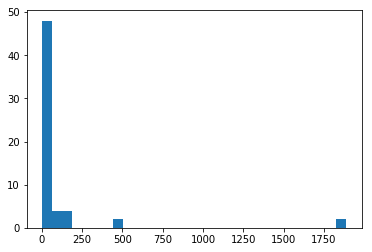

In [238]:
import matplotlib.pyplot as plt
submis = misfits[misfits['dist'] < 2500]
plt.hist(submis['dist'], bins = 30)
plt.show()

In [283]:
#More than 420 feet
misfits = misfits.sort_values(['ID', 'latitude_x_x'])
misfits[misfits['dist'] > 128]

,ID,latitude_x_x,longitude_x,count,start_x,end_x,longitude_y,latitude_x_y,coord,coord_avg,dist
2,160,40.44535,-73.97824,8,2016-09-14 15:41:52,2016-09-14 18:18:34,-73.978275,40.596795,"(40.44535, -73.97824)","(40.596795, -73.978275)",16817.158918
3,160,40.74824,-73.97831,55711,2013-07-01 01:15:36,2016-05-03 08:21:26,-73.978275,40.596795,"(40.74824, -73.97831)","(40.596795, -73.978275)",16817.601276
16,279,40.69987,-73.98272,3479,2013-07-01 05:59:31,2014-05-31 23:59:32,-73.992195,40.703870,"(40.69987, -73.98272)","(40.70387, -73.992195)",444.192599
17,279,40.70787,-74.00167,69342,2014-06-01 01:52:29,2016-12-31 22:39:30,-73.992195,40.703870,"(40.70787, -74.00167)","(40.70387, -73.992195)",444.192908
54,3016,40.72037,-73.96165,27844,2016-04-01 00:10:17,2016-12-31 20:24:35,-73.962417,40.737383,"(40.72037, -73.96165)","(40.7373833333, -73.9624166667)",1889.308056
55,3016,40.72073,-73.96126,409,2016-03-25 21:09:02,2016-03-31 22:44:01,-73.962417,40.737383,"(40.72073, -73.96126)","(40.7373833333, -73.9624166667)",1849.330592
56,3016,40.77105,-73.96434,1039,2015-08-01 07:17:17,2015-08-15 13:15:35,-73.962417,40.737383,"(40.77105, -73.96434)","(40.7373833333, -73.9624166667)",3738.655057
57,3036,40.51798,-74.03137,2,2016-12-02 14:03:11,2016-12-02 14:45:09,-74.028410,40.601425,"(40.51798, -74.03137)","(40.601425, -74.02841)",9266.184010
58,3036,40.68487,-74.02545,8,2016-07-12 15:01:45,2016-09-30 14:03:38,-74.028410,40.601425,"(40.68487, -74.02545)","(40.601425, -74.02841)",9266.318311


##### For the ending stations

In [251]:
#Verify consistency of coordinates
t0 = time.time()
funs = [count, min, max]
cols = ['stoptime']
aggs = [f(col(c)) for f in funs for c in cols]
lat_lon_end = trips.groupby(['end_station_id', \
                               'end_station_latitude', \
                               'end_station_longitude']).agg(*aggs)

ending = lat_lon_end.toPandas()
t1 = time.time()

ending.columns = ['ID', 'latitude', 'longitude', 'count', 'start', 'end']

In [265]:
coords_in_data = ending.groupby('ID').agg({'start': np.min, 'end':np.max, 'latitude': 'count'}).reset_index()
coords_in_data = coords_in_data[coords_in_data.latitude != 1]

In [268]:
nonfits = ending.merge(coords_in_data, on = 'ID')[['ID', 'latitude_x', 'longitude', 'count', 'start_x', 'end_x']]

In [274]:
nonfits = nonfits.merge(nonfits.groupby('ID').agg({'latitude_x': np.mean,
                                        'longitude' : np.mean}).reset_index(), on = 'ID')

In [275]:
nonfits['coord'] = list(zip(nonfits.latitude_x_x, nonfits.longitude_x))
nonfits['coord_avg'] = list(zip(nonfits.latitude_x_y, nonfits.longitude_y))

In [276]:
nonfits['dist'] = np.vectorize(lambda x, y:( VincentyDistance(x,y).meters))(nonfits['latitude_x_x'], nonfits['latitude_x_y'])

#### Taking out the Points

In [378]:
merged = x.merge(ending, on = ['ID', 'latitude', 'longitude'], how = 'outer')
merged = merged[merged['latitude'] > 0].sort_values(['ID', 'latitude', 'longitude'])

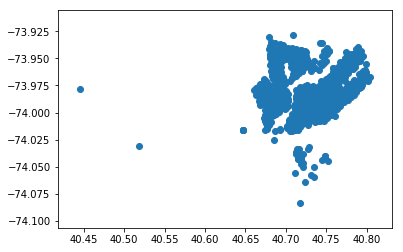

In [384]:
merged[merged['ID'].isin([160, 279, 3016, 3036])]

,ID,latitude,longitude,count_x,start_x,end_x,count_y,start_y,end_y
20,160,40.44535,-73.97824,8.0,2016-09-14 15:41:52,2016-09-14 18:18:34,8,2016-09-14 12:25:11,2016-09-14 17:47:55
21,160,40.74824,-73.97831,55711.0,2013-07-01 01:15:36,2016-05-03 08:21:26,55905,2013-07-01 07:32:21,2016-05-03 08:10:08
82,279,40.69987,-73.98272,3479.0,2013-07-01 05:59:31,2014-05-31 23:59:32,3704,2013-07-01 07:52:18,2014-05-31 23:52:53
83,279,40.70787,-74.00167,69342.0,2014-06-01 01:52:29,2016-12-31 22:39:30,71191,2014-06-01 00:41:00,2016-12-31 21:49:37
362,3016,40.72037,-73.96165,27844.0,2016-04-01 00:10:17,2016-12-31 20:24:35,29077,2016-04-01 01:23:26,2017-01-01 12:20:09
363,3016,40.72073,-73.96126,409.0,2016-03-25 21:09:02,2016-03-31 22:44:01,407,2016-03-25 19:20:52,2016-03-31 22:36:27
364,3016,40.77105,-73.96434,1039.0,2015-08-01 07:17:17,2015-08-15 13:15:35,992,2015-08-01 07:15:28,2015-08-15 13:19:29
366,3036,40.51798,-74.03137,2.0,2016-12-02 14:03:11,2016-12-02 14:45:09,2,2016-12-02 14:12:48,2016-12-02 14:47:40
367,3036,40.68487,-74.02545,8.0,2016-07-12 15:01:45,2016-09-30 14:03:38,8,2016-07-12 15:03:31,2016-09-30 14:07:57


In [386]:
merged = merged.drop([364, 366, 20, 82])

In [374]:
merged[merged['longitude'] == -73.989550]

,ID,latitude,longitude,count_x,start_x,end_x,count_y,start_y,end_y
200,402,40.74034,-73.98955,257860.0,2013-07-01 00:30:03,2016-12-31 22:32:31,266152,2013-07-01 06:26:25,2016-12-31 22:39:14
719,3439,40.74034,-73.98955,NaN,NaT,NaT,1,2016-11-21 12:17:14,2016-11-21 12:17:14


In [389]:
merged = merged[merged["ID"] != 3439]

In [392]:
lat_lon_table = merged.groupby("ID").agg({'latitude': np.mean, 'longitude':np.mean}).reset_index()

In [393]:
lat_lon_table

,ID,latitude,longitude
0,72,40.767270,-73.993930
1,79,40.719120,-74.006670
2,82,40.711170,-74.000170
3,83,40.683830,-73.976320
4,116,40.741780,-74.001500
5,119,40.696090,-73.978030
6,120,40.686770,-73.959280
7,127,40.731720,-74.006740
8,128,40.727100,-74.002970
9,137,40.761630,-73.972920


In [400]:
from sklearn.cluster import KMeans
geo_fit = KMeans(n_clusters = 25).fit(lat_lon_table[['latitude', 'longitude']])

In [402]:
lat_lon_table['cluster'] = geo_fit.labels_

In [ ]:
##To do: verify the clusters

### Create ML datasets

In [403]:
cluster_table = sc.createDataFrame(lat_lon_table)

AttributeError: 'SparkContext' object has no attribute 'createDataFrame'